In [224]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from geopandas import GeoDataFrame
import geopandas as gpd
from shapely.geometry import Point

import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from langdetect import detect

import plotly.express as px
import chart_studio.plotly as py
import chart_studio

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
pd.options.display.max_rows = 10000
pd.options.display.max_columns = 10000

In [7]:
listings = pd.read_csv('../london airbnb/listings.csv')

In [4]:
reviews = pd.read_csv('../london airbnb/reviews.csv')

In [3]:
calendar = pd.read_csv('../london airbnb/calendar.csv')

In [6]:
neig = pd.read_csv('../london airbnb/neighbourhoods.csv')

In [7]:
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

In [8]:
calendar.columns

Index(['listing_id', 'date', 'available', 'price', 'adjusted_price',
       'minimum_nights', 'maximum_nights'],
      dtype='object')

### Question1: How does the price change among the neighborhoods?

In [9]:
listings['price'] = listings['price'].str.replace(',', '').str.replace('$', '').astype(float)

In [10]:
# geojson file of neighboorhoods
street_map = gpd.read_file('C:/Users/kubra/Documents/Priv/Uda/first project/london airbnb/neighbourhoods.geojson')

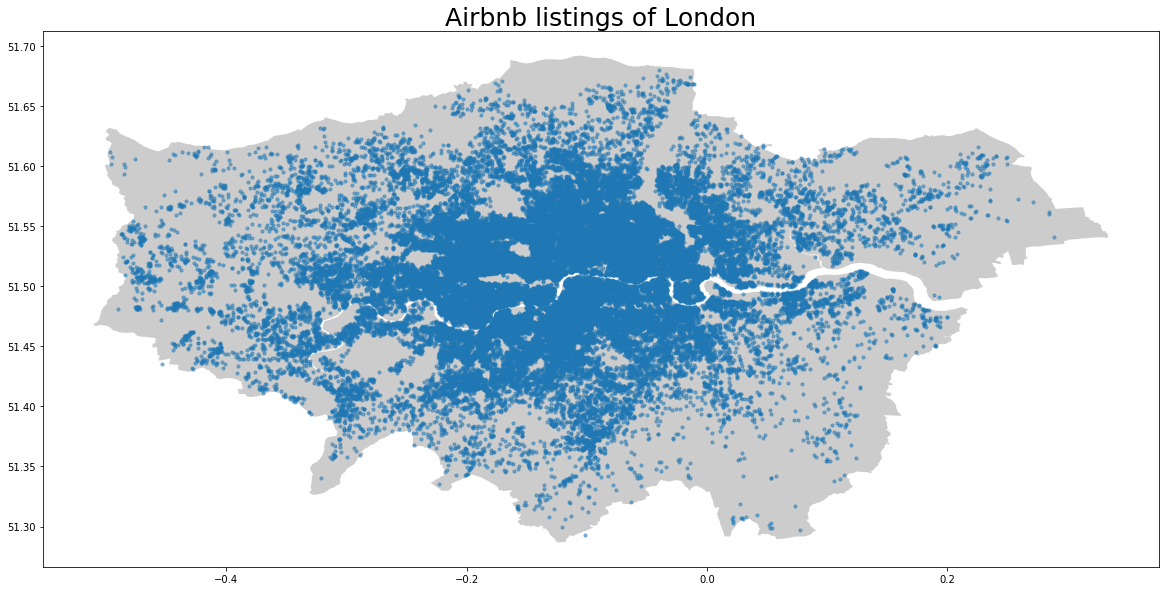

In [11]:
# plot the density of listings over London map as 'Airbnb listings of London'

df = listings.copy()

geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
# create GeoPandas dataframe
geo_df = gpd.GeoDataFrame(df, geometry = geometry)


fig, ax = plt.subplots(figsize=(20,20))
street_map.plot(ax=ax, alpha=0.4,color='grey')
geo_df.plot(ax=ax,alpha=0.5,markersize=10)
plt.title('Airbnb listings of London', fontsize=25)


plt.show()

In [12]:
# Finding average daily price per night by neighborhood
avg_price_neig= listings.groupby(["neighbourhood_cleansed"])["price"].mean().sort_values(ascending=False).reset_index()

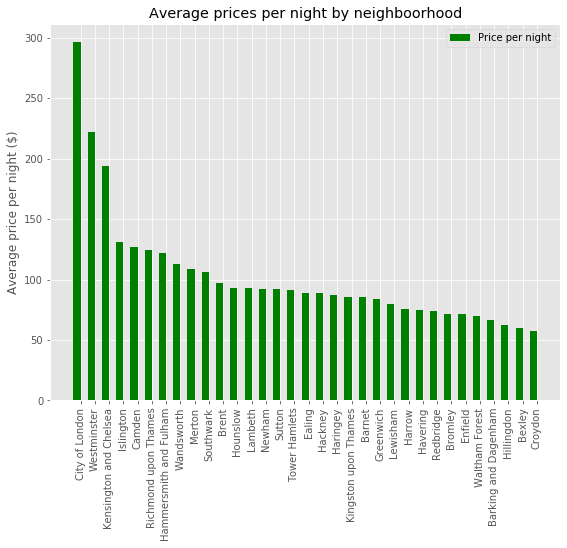

In [13]:
# plotting the neighborhoods and their average prices in order 

neighborhood = avg_price_neig["neighbourhood_cleansed"]
price = avg_price_neig['price']

x = np.arange(len(neighborhood))  # the label locations
width = 0.50  # the width of the bars

plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(8, 6))

rects1 = ax.bar(x - width/2, price, width, label='Price per night', color ='g')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average price per night ($)')
ax.set_title('Average prices per night by neighboorhood')
ax.set_xticks(x)
ax.set_xticklabels(neighborhood)
ax.legend()

fig.tight_layout()

plt.xticks(rotation=90)
plt.show()

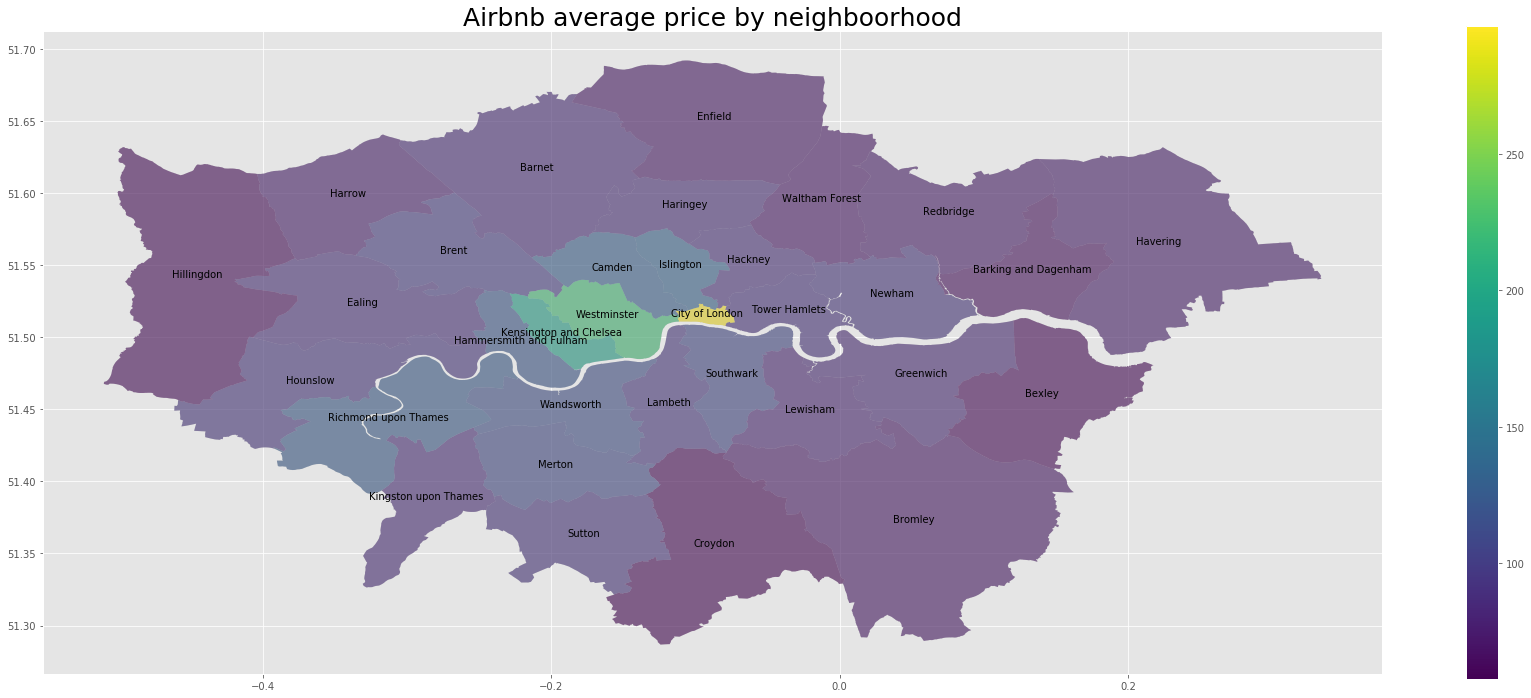

In [14]:
# Plotting the neighborhoods and average price by night on the London Map

data = pd.merge(street_map, avg_price_neig, left_on ='neighbourhood', right_on='neighbourhood_cleansed')

data['coords'] = data['geometry'].apply(lambda x: x.centroid.coords[:])
data['coords'] = [coords[0] for coords in data['coords']]

geometry = street_map['geometry']
geo_df2 = gpd.GeoDataFrame(data, geometry = geometry)

fig, ax = plt.subplots(figsize=(30,30))
street_map.plot(ax=ax, alpha=0.4,color='grey')
geo_df2.plot(column='price', ax=ax,alpha=0.5, legend=True,legend_kwds={'shrink': 0.4},markersize=10)

for _, row in data.iterrows():
    
    plt.text(s=row['neighbourhood_cleansed'], x = row['coords'][0], y = row['coords'][1],
            horizontalalignment='center', fontdict = {'size': 10})

plt.title('Airbnb average price by neighboorhood', fontsize=25)

plt.show()

### Question 2: Which neighborhood gets most positive reviews?

In [10]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,11551,30672,2010-03-21,93896,Shar-Lyn,"The flat was bright, comfortable and clean and..."
1,11551,32236,2010-03-29,97890,Zane,We stayed with Adriano and Valerio for a week ...
2,11551,41044,2010-05-09,104133,Chase,Adriano was a fantastic host. We felt very at ...
3,11551,48926,2010-06-01,122714,John & Sylvia,We had a most wonderful stay with Adriano and ...
4,11551,58352,2010-06-28,111543,Monique,I'm not sure which of us misunderstood the s...


In [ ]:
df2 = reviews.copy()

In [ ]:
df2 = df2.dropna(subset=['comments'], axis=0)

In [27]:
def language_detection(text):
    try:
        return detect(text)
    except:
        return None

In [28]:
df2['language'] = df2['comments'].apply(language_detection)

In [30]:
df2_en= df2[df2['language']=='en']

In [31]:
# Using sid for a comment 
sid = SentimentIntensityAnalyzer()
for sentence in df2_en['comments'].values[1:2]:
    print(sentence)
    ss = sid.polarity_scores(sentence)
    for k in sorted(ss):
        print (k,ss[k])
    print()

We stayed with Adriano and Valerio for a week when first moving to London. The apartment is great and very clean compared to a lot of places we've seen in London. Situated very close to Brixton tube and good bus links to central London. Thanks guys!
compound 0.9214
neg 0.0
neu 0.752
pos 0.248



In [16]:
sid = SentimentIntensityAnalyzer()
df2_en['scores'] = df2_en['comments'].apply(lambda review: sid.polarity_scores(review))

In [17]:
df2_en['compound']  = df2_en['scores'].apply(lambda score_dict: score_dict['compound'])
df2_en['neg']  = df2_en['scores'].apply(lambda score_dict: score_dict['neg'])
df2_en['neu']  = df2_en['scores'].apply(lambda score_dict: score_dict['neu'])
df2_en['pos']  = df2_en['scores'].apply(lambda score_dict: score_dict['pos'])

In [19]:
df2_en['compound_f']= np.where(df2_en['compound']>0,'pos','neg')

In [21]:
df2_en['compound_f'].value_counts()

pos    1025330
neg     153082
Name: compound_f, dtype: int64

In [38]:
df2_en_neig = pd.merge(df2_en, listings[['id','neighbourhood_cleansed']], left_on='listing_id', right_on='id')

In [118]:
df2_en_neig.to_excel('sentiment.xlsx')

In [65]:
df2_en_neig_gr = df2_en_neig.groupby(['neighbourhood_cleansed'])['compound_f'].value_counts().unstack()

In [83]:
# plotting number of positive comments
df2_en_neig_gr[['pos']].sort_values('pos',ascending=False).style.bar(subset=['pos'], align='mid', color=['#5fba7d'])

compound_f,pos
neighbourhood_cleansed,
Westminster,115553
Camden,82302
Tower Hamlets,80852
Kensington and Chelsea,69337
Lambeth,68147
Hackney,64861
Islington,64514
Southwark,62037
Hammersmith and Fulham,52591


In [84]:
# plotting # number of neg comments
df2_en_neig_gr[['neg']].sort_values('neg',ascending=False).style.bar(subset=['neg'], align='mid', color=['#d65f5f'])

compound_f,neg
neighbourhood_cleansed,
Westminster,6247
Tower Hamlets,4171
Camden,3724
Kensington and Chelsea,3333
Hackney,2954
Southwark,2803
Lambeth,2793
Islington,2601
Hammersmith and Fulham,2415


### Question3 : How do prices change during the time of the year?

In [4]:
calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,108562,2021-01-01,f,$35.00,$35.00,1.0,730.0
1,44237,2020-12-18,f,$55.00,$55.00,1.0,1125.0
2,44237,2020-12-19,f,$55.00,$55.00,1.0,1125.0
3,44237,2020-12-20,f,$55.00,$55.00,1.0,1125.0
4,44237,2020-12-21,f,$55.00,$55.00,1.0,1125.0


In [5]:
df3 = calendar.copy()

In [8]:
# Merging calendar and listings data to get the neighborhood of each listing
df3_neigh=pd.merge(calendar, listings[['id','neighbourhood_cleansed']], left_on='listing_id', right_on='id')

In [9]:
df3_neigh.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,id,neighbourhood_cleansed
0,108562,2021-01-01,f,$35.00,$35.00,1.0,730.0,108562,Islington
1,108562,2021-01-02,f,$35.00,$35.00,1.0,730.0,108562,Islington
2,108562,2021-01-03,f,$30.00,$30.00,1.0,730.0,108562,Islington
3,108562,2021-01-04,f,$30.00,$30.00,1.0,730.0,108562,Islington
4,108562,2021-01-05,f,$30.00,$30.00,1.0,730.0,108562,Islington


In [10]:
#Preparing related features 
df3_neigh['adjusted_price'] = df3_neigh['adjusted_price'].str.replace(',', '').str.replace('$', '').astype(float)
df3_neigh['date']=pd.to_datetime(df3_neigh['date'])

In [113]:
df3_neigh['date'].max(), df3_neigh['date'].min()

(Timestamp('2022-01-04 00:00:00'), Timestamp('2020-12-16 00:00:00'))

In [11]:
df3_neigh['months'] = df3_neigh['date'].apply(lambda x:x.strftime('%B'))

In [12]:
#Getting one year data of 2021
df3_neigh = df3_neigh[(df3_neigh['date']<'2022-01-01') & (df3_neigh['date']>'2020-12-31')]

In [36]:
df3_neigh_gr = df3_neigh.groupby(['neighbourhood_cleansed','months'])['adjusted_price'].mean().reset_index()

In [215]:
df3_neigh_gr.columns = ['Neighbourhood', 'Months', 'Average_Price']
df3_neigh_gr

,Neighbourhood,Months,Average_Price
0,Barking and Dagenham,April,65.165612
1,Barking and Dagenham,August,65.994427
2,Barking and Dagenham,December,65.805960
3,Barking and Dagenham,February,64.731144
4,Barking and Dagenham,January,64.536118
5,Barking and Dagenham,July,66.028177
6,Barking and Dagenham,June,65.732441
7,Barking and Dagenham,March,64.807001
8,Barking and Dagenham,May,65.590534
9,Barking and Dagenham,November,65.110624


In [230]:
## Connect with chartstudio
username = '' # Add your username
api_key = '' # Add your api key 

chart_studio.tools.set_credentials_file(username = username, api_key = api_key)

In [226]:
df = px.data.gapminder()
fig = px.area(df3_neigh_gr, x="Months", y="Average_Price", color="Neighbourhood",
   line_group="Neighbourhood")
fig.show()

In [231]:
py.plot(fig, filename = 'Monthly avg', auto_open=True)

'https://plotly.com/~kubrasen/1/'

### Question 4: Can we predict the price? 

Yes BUT score is not good. Need to work on model.
- Creating new features by Feature engineering
- Better tunning parameters

In [223]:
df = listings.copy()

In [224]:
df.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,11551,https://www.airbnb.com/rooms/11551,20201216161425,2021-01-04,Arty and Bright London Apartment in Zone 2,Unlike most rental apartments out there my fla...,Not even 10 minutes by metro from Victoria Sta...,https://a0.muscache.com/pictures/b7afccf4-18e5...,43039,https://www.airbnb.com/users/show/43039,Adriano,2009-10-03,"London, England, United Kingdom","Hello, I'm a friendly Italian man with a very ...",within an hour,100%,90%,f,https://a0.muscache.com/im/pictures/user/47773...,https://a0.muscache.com/im/pictures/user/47773...,Brixton,3.0,3.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"London, United Kingdom",Lambeth,NaN,51.46225,-0.11732,Entire apartment,Entire home/apt,4,NaN,1 bath,1.0,3.0,"[""Refrigerator"", ""Kitchen"", ""Crib"", ""Dedicated...",105.0,2,1125,2.0,2.0,1125.0,1125.0,2.0,1125.0,NaN,t,3,33,63,338,2021-01-04,192,6,0,2010-03-21,2020-03-26,91.0,9.0,9.0,10.0,10.0,9.0,9.0,NaN,t,2,2,0,0,1.46
1,13913,https://www.airbnb.com/rooms/13913,20201216161425,2020-12-18,Holiday London DB Room Let-on going,My bright double bedroom with a large window h...,Finsbury Park is a friendly melting pot commun...,https://a0.muscache.com/pictures/miso/Hosting-...,54730,https://www.airbnb.com/users/show/54730,Alina,2009-11-16,"London, England, United Kingdom",I am a Multi-Media Visual Artist and Creative ...,within a few hours,100%,75%,f,https://a0.muscache.com/im/users/54730/profile...,https://a0.muscache.com/im/users/54730/profile...,LB of Islington,3.0,3.0,"['email', 'phone', 'facebook', 'reviews', 'off...",t,t,"Islington, Greater London, United Kingdom",Islington,NaN,51.56802,-0.11121,Private room in apartment,Private room,2,NaN,1 shared bath,1.0,0.0,"[""Long term stays allowed"", ""Lock on bedroom d...",40.0,1,29,1.0,1.0,29.0,29.0,1.0,29.0,NaN,t,30,60,90,365,2020-12-18,21,1,0,2010-08-18,2020-02-22,97.0,10.0,10.0,10.0,10.0,9.0,9.0,NaN,f,2,1,1,0,0.17
2,15400,https://www.airbnb.com/rooms/15400,20201216161425,2020-12-28,Bright Chelsea Apartment. Chelsea!,Lots of windows and light. St Luke's Gardens ...,It is Chelsea.,https://a0.muscache.com/pictures/428392/462d26...,60302,https://www.airbnb.com/users/show/60302,Philippa,2009-12-05,"Kensington, England, United Kingdom","English, grandmother, I have travelled quite ...",NaN,NaN,100%,f,https://a0.muscache.com/im/users/60302/profile...,https://a0.muscache.com/im/users/60302/profile...,Chelsea,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"London, United Kingdom",Kensington and Chelsea,NaN,51.48796,-0.16898,Entire apartment,Entire home/apt,2,NaN,1 bath,1.0,1.0,"[""Refrigerator"", ""Wifi"", ""Heating"", ""Dishes an...",75.0,10,50,10.0,10.0,50.0,50.0,10.0,50.0,NaN,t,

In [225]:
#Finding indices of columns that has missing values 

def column_index(df, query_cols):
    cols = df.columns.values
    sidx = np.argsort(cols)
    return sidx[np.searchsorted(cols,query_cols,sorter=sidx)]
column_index(df, df.columns[df.isnull().any()])

array([ 4,  5,  6, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24,
       25, 26, 28, 34, 35, 36, 37, 42, 43, 44, 45, 46, 47, 48, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67, 73], dtype=int64)

In [200]:
# Dropping features that has more than %80 missing values

threshold = len(df) * 0.80
df=df.dropna(axis=1, thresh=threshold)

In [202]:
# Dropping irrelevant features
df = df.drop(['listing_url','scrape_id','last_scraped','name','description','picture_url', 'host_url',
             'host_name', 'host_thumbnail_url','host_picture_url','calendar_last_scraped','host_verifications','host_since',
             'latitude','longitude'],
             axis=1)

In [203]:
# Filling missing values 
def missing_value(df):
    for i in df.columns[df.isnull().any(axis=0)]:     
        if df[i].dtypes == 'object':
            df[i].fillna(df[i].mode(),inplace=True)
        else:
            df[i].fillna(df[i].mean(),inplace=True)
    return df

df = missing_value(df)

In [204]:
# Label Encoding categorical values

le = preprocessing.LabelEncoder()
df_cat = df.select_dtypes(include = 'object')

for col in df_cat:
    df[col] = df[col].astype(str)
    df[col] = le.fit_transform(df[col])

In [205]:
# Splitting training and test data
X = df.drop('price', axis=1)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

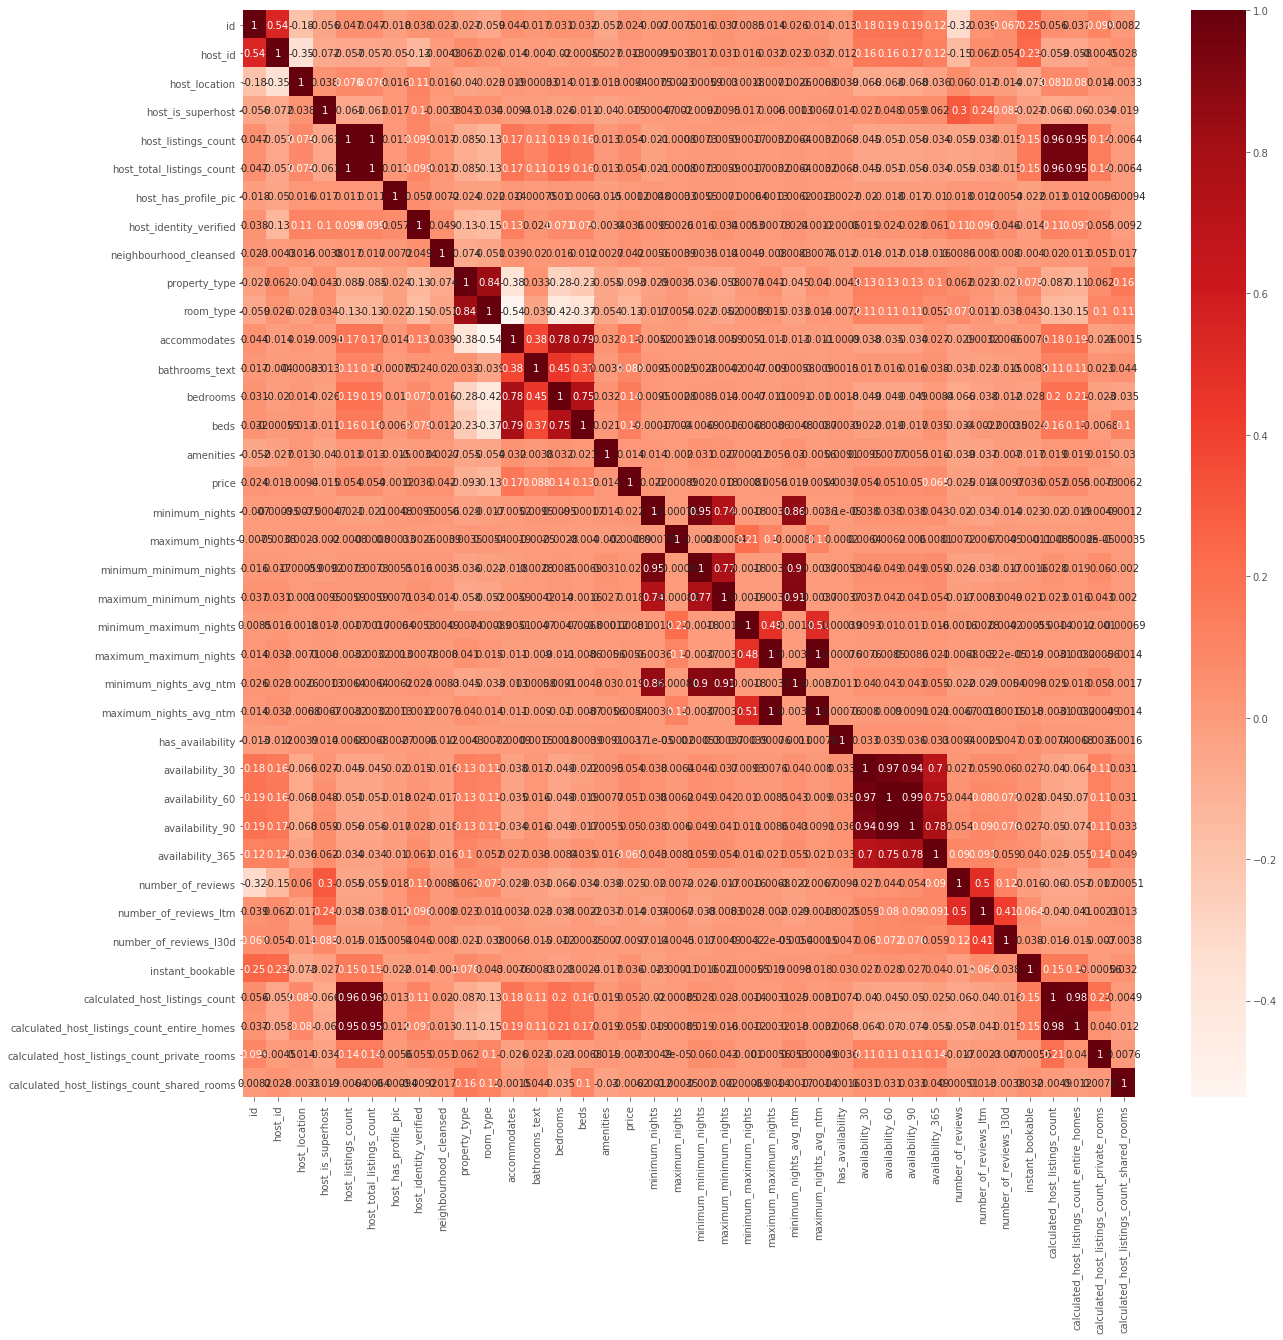

In [214]:
plt.figure(figsize=(10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [215]:
#  Using XGBregressor to training and hypertuning 
xgb = XGBRegressor(nthread=-1)
params = {'min_child_weight':[4,5], 'gamma':[i/10.0 for i in range(3,6)],  'subsample':[i/10.0 for i in range(6,11)],
'colsample_bytree':[i/10.0 for i in range(6,11)], 'max_depth': [2,3,4]}
gb = RandomizedSearchCV(estimator=xgb, param_distributions=params,scoring='r2')
gb.fit(X_train,y_train)
gb.best_score_
gb.best_params_

{'subsample': 0.9,
 'min_child_weight': 4,
 'max_depth': 4,
 'gamma': 0.5,
 'colsample_bytree': 0.6}

In [226]:
# Predicting price 
xgb = XGBRegressor()
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)
r = r2_score(y_pred, y_test)
print(r)

0.5066950770529492
